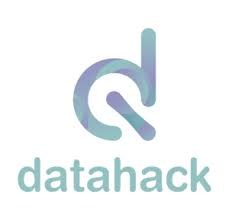

# <center>ANÁLISIS DE SENTIMIENTO: NLP</center>

Autor: [Santiago Moreno Gabaldón](https://www.linkedin.com/in/santiago-moreno-2a19a027/)

En este ejemplo vamos a ver cómo se hace un análisis de sentimiento utilizando NLP, es decir, procesamiento del lenguaje natural, que podría definirse como la rama de la Inteligencia Artificial que se ocupa del tratamiento del lenguaje humano.

Es una de las ramas más complejas e interesantes de la IA con gran cantidad de aplicaciones.

Se puede enfocar tanto desde un punto de vista de machine learning tradicional o del deep learning, si bien ambas tienen dos pasos fundamentales en común:

- Vectorización del texto, es decir, convertir de alguna manera los textos a vectores o tensores que los modelos de ML o DP entiendan;
- Aplicar la modelización, tanto supervisada como no supervisada sobre la vectorización anterior.

Así, podemos identificar una serie de aplicaciones tanto supervisadas como no supervisadas:
- Entre las no supervisadas, está la identificación automática de temáticas, clusterización o agrupación de textos por su contenido, resúmenes de textos...
- Entre las supervisadas, la clasificación automática de reclamaciones, sugerencias etc... para su correcto reenvío al departamento correspondiente o el análisis de supervivencia.




El ejemplo que vamos a ver hoy consiste en la aplicación de machine learning para un análisis de sentimiento basado en más de 700.000 valoraciones recogidas en Amazon.

Los pasos a seguir van a ser:

- Lectura de los datos;
- Visualización de los datos: tratamiento y limpieza;
- Vectorización;
- Aplicación de un modelo de clasificación.



## CARGA DE LIBRERÍAS Y LECTURA DE LOS ARCHIVOS

Se cargan las librerías así como los archivos para el análisis.

In [67]:
import pandas as pd
import numpy as np
import warnings
import time
import joblib
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score


warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth", 5000) 

In [2]:
camino="D:\\J\\Big data\\DATAHACK\\PYTHON\\Curso enero Datahack\\Practicas\\"
archivo="amazon_es_reviews.csv"

In [3]:
df_bruto=pd.read_csv(camino+archivo,sep=";")

Vemos cuántas tenemos en total:

In [4]:
df_bruto.shape

(702446, 2)

In [5]:
df_bruto.head()

,comentario,estrellas
0,"Para chicas es perfecto, ya que la esfera no e...",4.0
1,Muy floja la cuerda y el anclaje es de mala ca...,1.0
2,"Razonablemente bien escrito, bien ambientado, ...",3.0
3,Hola! No suel o escribir muchas opiniones sobr...,5.0
4,A simple vista m parecia una buena camara pero...,1.0


In [80]:
df_bruto["estrellas"].value_counts().sort_index()

1.0    117416
2.0     78597
3.0    142698
4.0    152611
5.0    211124
Name: estrellas, dtype: int64

Tenemos 702446 cometarios en total clasificados con distintos valores, desde 1 estrella hasta 5.

Queremos convertirlo en un modelo de clasificación binario que nos devuelva "positivo" o "negativo" con lo que vamos a considerar valores inferiores a 4 como negativos y el resto como positivos.

Añadimos una columna más de nombre "target":

In [6]:
df_bruto["target"]=np.where(df_bruto["estrellas"]<4,0,1)

In [43]:
df_bruto.head()

,comentario,estrellas,target,comentario_limpio,saco_palabras
0,"Para chicas es perfecto, ya que la esfera no es muy grande y la correa se adapta a las muñecas más finas. Un pelín gordo (para mi gusto). La carga por movimiento no dura mucho. Después de 1-2 días sin llevarlo se para.",4.0,1,"para chicas es perfecto, ya que la esfera no es muy grande y la correa se adapta a las muñecas mas finas. un pelin gordo (para mi gusto). la carga por movimiento no dura mucho. despues de 1-2 dias sin llevarlo se para.","[para, chicas, es, perfecto, ya, que, la, esfera, no, es, muy, grande, y, la, correa, se, adapta, a, las, muñecas, mas, finas, un, pelin, gordo, para, mi, gusto, la, carga, por, movimiento, no, dura, mucho, despues, de, 1, 2, dias, sin, llevarlo, se, para]"
1,Muy floja la cuerda y el anclaje es de mala calidad. El metal Se dobla muy fácilmente. No lo recomiendo,1.0,0,muy floja la cuerda y el anclaje es de mala calidad. el metal se dobla muy facilmente. no lo recomiendo,"[muy, floja, la, cuerda, y, el, anclaje, es, de, mala, calidad, el, metal, se, dobla, muy, facilmente, no, lo, recomiendo]"
2,"Razonablemente bien escrito, bien ambientado, quizás previsible, pero historia interesante. Los personajes están muy bien dibujados. Me parece un libro recomendable.",3.0,0,"razonablemente bien escrito, bien ambientado, quizas previsible, pero historia interesante. los personajes estan muy bien dibujados. me parece un libro recomendable.","[razonablemente, bien, escrito, bien, ambientado, quizas, previsible, pero, historia, interesante, los, personajes, estan, muy, bien, dibujados, me, parece, un, libro, recomendable]"
3,"Hola! No suel o escribir muchas opiniones sobre los productos que compro pero la verdad, este producto lo merece! Yo estaba desencantado con las máquinas de afeitar porque hace años me compré una Philips con cuchillas rotatorias. Yo tengo la piel extremadamente sensible y al usar esa afeitadora me hice polvo la cara, vamos en carne viva me la dejé. La volví a usar otra vez más y fue más de lo mismo, a parte de no apurar bien la barba. Así que, después de esta mala experiencia me pasé a las cuchillas Gillette mach3 que la verdad me iban mejor pero también me dejaban la cara con un ardor que me duraba un día. Hace varias semanas leyendo mucho en foros y demás, vi que las afeitadoras con cuchillas en láminas funcionan mejor para pieles muy delicadas y además apuran más. Así que me dediqué a investigar y me decidí a comprar una de estas. Mi duda era si comprar una Braún o Panasonic y obviamente me decidí por la segunda. Para conseguir las prestaciones y potencia de la Panasonic en Braún tenía que pagar el doble y como no sabía si finalmente me iba a ir bien me decidí por esta Panasonic. Mi experiencia después de varias semanas de uso es excelente! Una máquina con muy buena calidad de materiales, robusta, muy ergonómica, el resultado del apurado es buenísimo, es muy potente y encima la batería carga en tan sólo una hora y ya llevo cinco afeitadas y sigue con batería! Una maravilla. Se limpia súper fácil y la puedes usar en seco y en mojado debajo de la ducha o con espuma o gel de afeitar! Ah, y lo más lo más importante es que no me ha dañado nada en absoluto la piel, ni rojeces ni escozor. Trae un recortador de patillas y bigote pero eso aun no lo he usado. Afeita muy bien tanto en cuello y cara. Sin duda la recomiendo al cien por cien, es una pasada. Nada que ver con el mal apurado de las cuchillas rotatorias de las Philips.",5.0,1,"hola! no suel o escribir muchas opiniones sobre los productos que compro pero la verdad, este producto lo merece! yo estaba desencantado con las maquinas de afeitar porque hace años me compre una philips con cuchillas rotatorias. yo tengo la piel extremadamente sensible y al usar esa afeitadora me hice polvo la cara, vamos en carne viva me la deje. la volvi a usar otra vez mas y fue mas de lo mismo, a parte de no apurar bien la barba. asi que, despues de esta mala experiencia me pase a las cu

In [81]:
df_bruto["target"].value_counts()

1    363735
0    338711
Name: target, dtype: int64

Estamos de suerte. Nos ha quedado un dataset equilibrado, en el sentido de que tenemos prácticamente la mitad de cada tipo de respuestas. Esto nos va a permitir utilizar la métrica de accuracy como adecuada para entrenar el modelo

## LIMPIEZA DE TEXTO:

Normalmente, los textos no vienen limpios o, directamente, se utilizan lenguajes como python que son "case-sensitive" es decir, par los que "Madre" es distinto a "madre". Asimismo, en los procesos de limpieza más habituales consisten en eliminar tildes y algunos pasos más que se indican a continuación:

    1- Pasamos a minúsculas
    2- Quitamos tildes
    3- Eliminamos "caracteres raros" quedándonos solo con las palabras.
    4- "Tokenizamos", es decir, partimos las frases en palabras.

In [8]:
df_bruto["comentario_limpio"]=df_bruto["comentario"].apply(lambda x: x.lower())
df_bruto["comentario_limpio"]=df_bruto["comentario_limpio"].apply(lambda x: x.replace("á","a").replace("é","e").replace("í","i").replace("ó","o").replace("ú","u"))

In [9]:
df_bruto.head()

,comentario,estrellas,target,comentario_limpio
0,"Para chicas es perfecto, ya que la esfera no e...",4.0,1,"para chicas es perfecto, ya que la esfera no e..."
1,Muy floja la cuerda y el anclaje es de mala ca...,1.0,0,muy floja la cuerda y el anclaje es de mala ca...
2,"Razonablemente bien escrito, bien ambientado, ...",3.0,0,"razonablemente bien escrito, bien ambientado, ..."
3,Hola! No suel o escribir muchas opiniones sobr...,5.0,1,hola! no suel o escribir muchas opiniones sobr...
4,A simple vista m parecia una buena camara pero...,1.0,0,a simple vista m parecia una buena camara pero...


Se ve cómo en el caso de los comentarios limpios ya no hay tildes y está todo en minúsculas. Sin embargo, aun se aprecian caracteres "extraños" como "!". Así, si no se eliminaran estos, pàlabras como hola y hola! se considerarían iguales.

Esta limpieza se va a incluir dentro del último paso, como es la tokenización, último paso pendiente.

En NLP se entiende por corpus al conjunto de documentos disponibles, es decir, en este casos, todas las opiniones de amazon, siendo un documento cada una de estas opiniones.

En el objetivo final, de cara al entrenamiento, vamos a traducir cada uno de estos documentos en un vector numérico, es decir, tendremos una tabla con tantos registros como opiniones. Cada documento anterior se separa en la unidad menor, es decir, en palabras ASí, en realidad, el proceso de tokenización consiste en separar en palabras los comentarios anteriores.

Esto no siempre es así, es decir, la unidad mínima no tiene por qué ser la palabra sino, por ejemplo, la letra o incluso frases enteras.

No obstante, lo más habitual como en este caso, la tokenización se va a referrir a las palabras y todos los modelos se van a basar en encontrar patrones de palabras asociadas a los comentarios positivos y a los negativos.

Un tokenizador se ocupa de transformar los documentos. Adicionalmente, las opciones que vienen con librerías como nltk permiten que durante el propio proceso de tokenización se incluyan también ciertas limpiezas de texto.

En el ejemplo siguiente, veremos cómo:

In [10]:
# Importamos el RegexpTokeziner
from nltk.tokenize import RegexpTokenizer

# Creamos una instancia del mismo, diciéndole
# la expresión regular que utilizará para separar
# el string en tokens:
nuestro_tokenizer = RegexpTokenizer("[\w']+") # Ese string raro es una expresión regular,
                                              # que básicamente quiere decir: "selecciona"
                                              # secuencias de caracteres de forma conjunta,
                                              # siempre y cuando sean letras de la A-Z, a-z,
                                              # 0-9 y _. En cuanto te encuentres con un caracter
                                              # que no sea uno de esos, dejas de seleccionar.

# Y lo aplicamos:


Veamos cómo funciona el tokenizador con una frase:

In [11]:
frase="Hola. Me llamo ¡¡Santiago!! y python es lo mejor ¿A que si? #Sin duda# U(casi)"

In [12]:
nuestro_tokenizer.tokenize(frase)

['Hola',
 'Me',
 'llamo',
 'Santiago',
 'y',
 'python',
 'es',
 'lo',
 'mejor',
 'A',
 'que',
 'si',
 'Sin',
 'duda',
 'U',
 'casi']

In [ ]:
type(nuestro_tokenizer.tokenize(frase))

Se puede ver perfectamente cómo el resultado de aplicar el tokenizador ya no es un string, es decir, un texto, sino una lista que contiene textos en este caso separados por los espacios. Además, todos los caracteres que no son letras se han elminado.

Podemos aplicar este tokenizador a nuestos comentarios limpios que ya no tienen ni tildes y están en minúsculas:

In [13]:
df_bruto["saco_palabras"]=df_bruto["comentario_limpio"].apply(lambda x:nuestro_tokenizer.tokenize(x) )

In [14]:
df_bruto.head()

,comentario,estrellas,target,comentario_limpio,saco_palabras
0,"Para chicas es perfecto, ya que la esfera no e...",4.0,1,"para chicas es perfecto, ya que la esfera no e...","[para, chicas, es, perfecto, ya, que, la, esfe..."
1,Muy floja la cuerda y el anclaje es de mala ca...,1.0,0,muy floja la cuerda y el anclaje es de mala ca...,"[muy, floja, la, cuerda, y, el, anclaje, es, d..."
2,"Razonablemente bien escrito, bien ambientado, ...",3.0,0,"razonablemente bien escrito, bien ambientado, ...","[razonablemente, bien, escrito, bien, ambienta..."
3,Hola! No suel o escribir muchas opiniones sobr...,5.0,1,hola! no suel o escribir muchas opiniones sobr...,"[hola, no, suel, o, escribir, muchas, opinione..."
4,A simple vista m parecia una buena camara pero...,1.0,0,a simple vista m parecia una buena camara pero...,"[a, simple, vista, m, parecia, una, buena, cam..."


En principio, con esto se termina el pretratamiento de textos. Tras esto, ya tenemos el texto lo más homogéneo posible y listo para poder vectorizarlo.

## Vectorización



### Saco de palabras

Los modelos solo entienden una cosa: números. Esto significa que todo modelo de NLP debe, en algún momento, traducir las palabras a números.

Existen varias formas de hacerlo, de las que vamos a ver las más habituales. Comenzaremos por el saco de palabras o "bag of words", que consiste en que en el corpus se obtienen todas las palabras distintas y cada frase se traduce en un vector que lo que tiene es el total de veces que aparece cada palabra en la frase;

Veámoslo con un ejemplo sencillo. Para ello nos vamos a ayudar de CountVectorizer de sklearn que ya automáticamente nos va a crear la matriz que buscamos. 


In [16]:
from sklearn.feature_extraction.text import CountVectorizer

Sklearn es una biblioteca realmente magnífica. Antes hemos visto cómo hacer "a mano" el proceso de limpieza. Sin embargo, sklearn nos va a permitir incluir todos estos pasos dentro del propio vectorizador. Lógicamente, esto nos va a simplicar mucho el trabajo posterior.

En la documentación, que es excelente y apenas hace falta más para aprender bien machine learning, se indica lo siguiente para la selección que vamos a hacer:

    - strip_accents: Remove accents and perform other character normalization during the preprocessing step. ‘ascii’ is a fast method that only works on characters that have an direct ASCII mapping. ‘unicode’ is a slightly slower method that works on any characters. None (default) does nothing.
    -analyzer: Si se indica word, el tokenizado es a nivel de palabras;
    - tokenizer: incluye el tokenizador que hemos generado, que además, nos incluye la limpieza con expresión regular;
    - lowercase: Si es True, se convierte a minúsculas todo el texto

In [45]:
vectorizador=CountVectorizer(strip_accents="ascii", # Quita las tildes de las palabras
                                   analyzer="word", # Le dice al tokenizer que los tokens deben ser palabras
                                   tokenizer=nuestro_tokenizer.tokenize, # La función de nuestro tokenizer
                                                                         # que hicimos con NLTK
                                   lowercase=True # Que convierta todo a minúsculas
                                  )

Tras tener el vectorizador construido, hay que entrenarlo, es decir, que aprende las palabras que existen y cuántas hay en cada documento. De nuevo, vamos a tomar un corpus sencillo solamente con tres frases:

In [53]:
corpus_sencillo=["Hola. El perro es blanco", "Mi vecino tiene un perro negro y un perro marrón","tu vecino tiene un gato"]

In [54]:
vectorizador.fit(corpus_sencillo)

CountVectorizer(strip_accents='ascii',
                tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="[\\w']+", gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>)

Tras entrenarlo, veamos el vocabulario que ha capturado:

In [55]:
vectorizador.vocabulary_

{'hola': 4,
 'el': 1,
 'perro': 8,
 'es': 2,
 'blanco': 0,
 'mi': 6,
 'vecino': 12,
 'tiene': 9,
 'un': 11,
 'negro': 7,
 'y': 13,
 'marron': 5,
 'tu': 10,
 'gato': 3}

Se comprueba cómo dentro del vocabulario, ya está todo en minúsculas y no hay puntos. Ahora que está ya entrenado, lo único que hay que hacer es transformar el texto para obtener los deseados vectores. 

Sklearn unifica los métodos para los modelos de machine learning en cuatro:
    - fit: Entrena, válido para todo tipo de modelos;
    - transform: Se aplica a aquellos modelos que no devuelven uan predicción como tal, sino que toman unos datos y los transforman en otros datos normalmente como paso previo a algún tipo de predicción. Devuelven un dataframe o dataset;
    - predict: asociado a modelos predictivos supervisados y no supervisados que devuelven un valor puntual a un conjunto de datos;
    - fit_transform: al tiempo que entrenan devuelven un dataset ya transformado. En realidad, unifica el fit y el transform en el mismo paso.
    
Para ver el resultado, aplicamos el transform a nuestro corpus:

In [56]:
vectorizador.transform(corpus_sencillo)

<3x14 sparse matrix of type '<class 'numpy.int64'>'
	with 18 stored elements in Compressed Sparse Row format>

Devuelve un objeto "raro" que es una sparse matrix. Una sparse matrix o matriz dispersa es un tipo de matriz pensado para un óptimo almacenamiento para objetos que tienen muchos ceros. ASí, lo que se guarda es el vector que indica la posición para los valores no nulos y el propio valor, obviando todos los que sean ceros.

Para visualizarlo, tenemos que convertirlo en array:

In [57]:
vectorizador.transform(corpus_sencillo).toarray()

array([[1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 0, 2, 1, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0]], dtype=int64)

¿Cómo interpretamos el array de arriba? Por ejemplo, si tomamos del vocabulario la primera palabra vemos que es 'hola':4 . Esto significa que el hola se guarda en la cuarta columna. Vemos, que, en efecto, la primera fila del array tiene un 1 en la posición 4 (en realidad hay que mirar la 5, porque python indexa desde 0) y el resto ceros.

In [58]:
vectorizador.transform(corpus_sencillo).toarray()[:,4] 

array([1, 0, 0], dtype=int64)

Si buscamos la palabra perro, tenemos que ver la 8 columna y aparece en los dos primero documentos y no en el tercero. Tiene que aparece un 1 en el primer documento, un 2 en el segundo (aparece dos veces) y un 0 en el tercero:

In [59]:
vectorizador.transform(corpus_sencillo).toarray()[:,8] 

array([1, 2, 0], dtype=int64)

## ENTRENAMIENTO DEL MODELO

Tras entender cómo funciona un vectorizador, ya estmamos en disposición de entrenar un modelo que nos anticipe el sentimiento de un comentario proporcionado de antemano.

Para ello, el primer paso, es separar nuestr conjunto en train y test.

In [22]:
from sklearn.model_selection import train_test_split

df_entrenar=df_bruto[["comentario","target"]]
train,test=train_test_split(df_entrenar,train_size=0.75,random_state=42)




Es importante aquí notar que el fit, es decir, el entrenamiento no ya del modelo sino del propio vectorizador, ha de hacerse sobre el train, nunca sobre el test.

Hay que entender que el train representa lo conocido a día de hoy y el test lo que está por venir. Si en el futuro apareciera una palabra por primera vez, nuestro vectorizador no puede tenerla en cuenta, es decir, se ignorará. De ahí que para saber realmente cómo se comporta nuestro modelo, tengamos que utilizar solo la parte de test. En resumen:

    - Se entrena el vectorizador con el train;
    - Se vectorizan después con transform tanto el train como el test;
    - Se entrena el modelo de clasificación con el train;
    - Se evalúa con el test.

In [60]:
ahora=time.time()
vectorizador.fit(train["comentario"]) ### Entrenamiento con train
X_train=vectorizador.transform(train["comentario"]) ##Vectorización del conjunto de train
X_test=vectorizador.transform(test["comentario"]) ##Vectorización del conjunto de test
y_train=train["target"]  ##Vector con la target para train
y_test=test["target"] ##Vector con la target para test
tiempo_total=time.time()-ahora
print("Tiempo de entrenamiento: %s" %tiempo_total)

Tiempo de entrenamiento: 37.50341510772705


Si vemos qué es X_train:

In [61]:
print(type(X_train))
print(X_train.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(526834, 231492)


De nuevo tenemos una matriz sparse con 526834 filas o comentarios y..... ¡¡231492 columnas o variables!!!

Aquí encontramos uno de los principales problemas del NLP y es que se crean unas matrices inmensas que ralentizan mucho los procesos y requiren mucha memoria. Ahí la razón de utilizar las matrices sparse y otro tipo de soluciones parecidas. Lo malo es que vamos a ver que este problema solo va a ir en aumento y enseguida se entenderá con facilidad el motivo.

De momento, entrenemos una regresión logística:

In [62]:
from sklearn.linear_model import LogisticRegression

In [63]:
lr=LogisticRegression()

In [64]:
ahora=time.time()

lr.fit(X_train,y_train)

tiempo_total=time.time()-ahora

print("Tiempo de entrenamiento: %s" %tiempo_total)

Tiempo de entrenamiento: 12.63174557685852


Puntuaciones en train y test:

In [65]:
lr.score(X_test,y_test)

0.8306323030316834

In [66]:
lr.score(X_train,y_train)

0.8401830557632954

Bueno, pues nuestro primer modelo no ha funcionado nada mal. Ha obtenido un 83 % de aciertos en test y un 84 % en train. Veamos alguna métrica adicional:

In [78]:
print("Porcentaje de unos capturados por el modelo:")
print(np.round(recall_score(y_true=y_test,y_pred=lr.predict(X_test)),3))

print("Precisión en la captura de unos:")
print(np.round(precision_score(y_true=y_test,y_pred=lr.predict(X_test)),3))

print("Área curva roc:")
print(np.round(roc_auc_score(y_true=y_test,y_score=lr.predict_proba(X_test)[:,1]),3))

Porcentaje de unos capturados por el modelo:
0.838
Precisión en la captura de unos:
0.835
Área curva roc:
0.904


## "STOP WORDS",  LEMATIZACIÓN (STEAMING) Y NGRAMAS


El modelo anterior es casi lo más sencillo que se le puede pedir a un modelo de NLP. En definitiva, solamente hemos contado palabras. Nuestras variables son el número de palabras que aparecen en un documento del corpus cuando aparecen. 

Pero es fácil darse cuenta de unas limitaciones muy básicas:

    - No todas las palabras aportan el mismo significado. Es decir, no es lo mismo que la palabra "el" aparezca mil veces a que lo haga la palabra "excelente". Ambas aportan un valor claramente diferente a la hora de juzgar el producto;
    
    - La Inteligencia Artificial, por muy inteligente que parezca es bastante tonta. En este ejemplo, ha considerado palabras diferentes bueno y buena, por poner un ejemplo sencillo, cuando en realidad deberían ser lo mismo;
    
    - Las palabras se analizan como algo aislado. De este modo se pueden perder negaciones. No es lo mismo que se diga "es bueno"  a "no es bueno" y en realidad, el modelo es incapaz de capturar las relaciones entre palabras. Este último punto sí se consigue con técnicas de redes recurrentes lo que ha popularizado mucho su uso, si bien tienen otro tipo de limitaciones.
    
    



Las tres limitaciones anteriores no son las únicas, pero sí son las más inmediatas. De hecho, más adelante veremos un par más pero no tanto asociadas a las palabras en sí como al modo en que se están contabilizando. 

Como son las más frecuentes, las bibliotecas de machine learning nos proporcionan distintas soluciones para lidiar con estos problemas.

### STOP WORDS

Se entiende por "stop words" una serie de palabras que apenas aportan significado a una frae, tales como artículos, pronombres, preposiciones, verbos copulativos, etc...

Lo habitual en NLP es eliminar estas palabras directamente. Veamos cómo obtener un listado de ellas:

In [82]:
from nltk.corpus import stopwords

stopwords_castellano = stopwords.words("spanish")

print(stopwords_castellano)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

Aquí tenemos algunas. Podríamos añadir o quitar a esta lista las que quisiéramos, e incluso crear la nuestra propia. Por comodidad, mantendremos esta.

### LEMATIZACIÓN

La lematización o "stemming" es el proceso de reducir una palabra a su lexema, es decir, al morfema que aporta el significado de la palabra. En español, donde las palabras tienen género y número, los morfemas de género y número no aportan significado real a la palabra; así, da igual a efectos de significado decir buenos, bueno, buenas o buena. 

El proceso de lematización precisamente trata de convertir ambos en "buen" de modo que se identifiquen con la misma palabra.

A diferencia de la eliminación de stopwords es un problema más complicado de resolver manualmente y nos ayudaremos de un lematizador ya creado. En este caso, del módulo NLTK:

In [83]:
from nltk.stem.snowball import SpanishStemmer

stemmer_castellano = SpanishStemmer()

print(stemmer_castellano.stem("bueno"))
print(stemmer_castellano.stem("buenas"))
print(stemmer_castellano.stem("buen"))

buen
buen
buen


Parece que ha funcionado como esperábamos.

Veamos ahora cómo integrarlo en el tokenizador. Tenemos que pasar a cada una de las palabras que devuelve el tokenizador el proceso de steamming.

Realmente podríamos incluir aquí también una comprobación de si la palabra es o no stop word de manera sencilla. Sin embargo, lo vamos a dejar porque sklearn nos va a proporcionar un modo más sencillo de hacerlo.

Creamos una función que nos tokenice el texto:

In [84]:
def tokenizando_lematizando(frase):
    """Esta función recibe una frase entera, elimina los caracteres raros y después le aplica el lematizado"""
    return [stemmer_castellano.stem(palabra) for palabra in nuestro_tokenizer.tokenize(frase)]

### n-grams.

Finalmente, vamos a intentar conseguir que el modelo capte cierta interrelación entre palabras o expresiones. Para ello se recurre al concepto de ngrama. 

Un ngrama no es más que considerar como palabra un conjunto de n palabras. Un bigrama tomará palabras de dos en dos y un trigrama de tres en tres. ASí, supongamos que queremos utilizar bigramas en la frase:

"El pan está muy rico" 

El vectorizador no solo considerará [el,pan,esta,muy,rico] sino que añadira las combinaciones de dos en dos aumentando el vocabulario:

[el,pan,esta,muy,rico, el pan, pan está, está muy, muy rico]

Este es el motivo por el cual ya se indicó que el problema de la dimensionalidad en nlp no haría más que crecer.


## TF-IDF


El último concepto que vamos a de nlp con machine learning es el de tf-idf.

Si hasta ahora hemos tratado de solventar las limitaciones relativas al vocabulario con ngramas, sotp words y lematización, ahora vamos a ir al modeo en que se contabiliza el vocabulario mismo.



### TF

El countvectorizer que hemos utilizado con buenos resultados antes solamente contabilizaba el número de palabras que aparecen en una expresión.

No obstante, parece razonable plantear que no es lo mismo que una palabra aparezca 4 veces en un documento de 10 palabras a que aparezca 4 veces en un documento de 400. 

Para tratar de modo relativo el número de veces que aparece una palabra, se utiliza el TF o "term frequency". Este no va a asignar el número de veces que aparece el token en particular, sino que lo va a poner en relación con la longitud del texto, exactamente lo que se buscaba.


###  IDF

IDF es la abreviatura de "inverse document frequency". Si el TF trata de capturar la frecuencia en un documento de cada token, el IDF intenta reflejar el hecho de que determinadas palabras, aunque sean poco frecuentes,  van a influir mucho en el resultado a la hora de catalogar un documento en un sentido determinado.

En IDF va a considerar cómo una palabra aparece no ya en un documento sino en todo el corpus. Para calcularlo se siguen los siguientes pasos:

- Se cuenta el número de documentos en que aparece el token para el que se va a calcular el IDF;
- Se divide el valor anterior por el total de documentos que componen el corpus.



Existen distintas expresiones para computar el TIDF, si bien todas responden al mismo principio anterior. Se va a utilizar en el ejemplo la de sklearn:






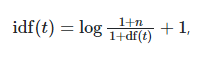

### TF-IDF


Finalmente, el TF-IDF no es más que multiplicar en cada documento el TF calculado antes por el valor del IDF del token. Con esto lo que se obtienen son mayores pesos para tokens frecuentes en el documento en cuestión pero que aparecen en pocos documentos, es decir, al final es una forma de ponderar más aquellas palabras menos frecuentes a nivel de corpus, debido a que se supone que proporcionarán más información.






Como último paso del ejemplo se va tokenizar el texto utilizando el tfidf de skleanr. En el ejemplo se ver con facilidad cómo el propio tokenizador nos va a permite meter tanto los ngramas como las stopwords- Recordar que el steamming lo hemos asociado directamente al tokenizador

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer

Tf_idf_lemas_steamming = TfidfVectorizer(strip_accents="ascii", ###Caracteres ascii eliminando acentos
                                     analyzer="word",  ##Tokenizado a nivel de palabra
                                     stop_words=stopwords_castellano, ## Listado con los stopwrods
                                     tokenizer=tokenizando_lematizando,  ##Nuestro tokenizador-lematizador-limpiador de caracteres
                                     lowercase=True, ##Texto en minúsculas
                                     ngram_range=(1,3) ##Se van a construir ngramas de rango 1 a 3, es decir, bigramas y trigramas
                                    )

Apliquémoslo a nuestro corpus sencillo:

In [86]:
corpus_sencillo

['Hola. El perro es blanco',
 'Mi vecino tiene un perro negro y un perro marrón',
 'tu vecino tiene un gato']

In [87]:
###Aquí el método fit_transform nos va a devolver el array resultante
Tf_idf_lemas_steamming.fit_transform(corpus_sencillo).toarray()

array([[0.42339448, 0.        , 0.42339448, 0.42339448, 0.42339448,
        0.        , 0.        , 0.        , 0.        , 0.32200242,
        0.42339448, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.26679669, 0.26679669, 0.26679669, 0.26679669, 0.40581153,
        0.        , 0.26679669, 0.26679669, 0.26679669, 0.20290576,
        0.        , 0.26679669, 0.26679669, 0.20290576, 0.20290576,
        0.        , 0.26679669],
       [0.        , 0.45954803, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.34949812,
        0.45954803, 0.        , 0.        , 0.34949812, 0.34949812,
        0.45954803, 0.        ]])

In [88]:
Tf_idf_lemas_steamming.fit_transform(corpus_sencillo).toarray().shape

(3, 22)

Ya aparecen números más difíciles de entender como consecuencia de haber aplicado el tf-idf. ADemás, estos números están siempre entre 0 y 1 por un criterio interno de normalización que aplica sklearn. Se puede notar cómo el número de columnas para un corpus tan sencillo es ya de 22. Veámoslo con el ejemplo completo.

Aquí, por motivos de tiempo, no vamos a entrenar el vectorizador. Tarda 1143 segundos, es decir, casi 20 segundos en hacer el proceso entero. Por esta razón, vamos a importarlo. Como es muy pesado, se reduce a 10 minutos, pero algo es algo.


No obstante, se incluye también el codigo para su entrenamiento. El que se entrene o no, se va a controlar con una variable booleana que tomara True para entrar y False para no:

In [89]:
ahora=time.time()
entrenar=False
if entrenar:
    print("Opción de entrenamiento seleccionada")
    
    Tf_idf_lemas_steamming.fit(train["comentario"])
    tiempo_total=time.time()-ahora
    print("Entrenamiento completado tiempo empleado: %s" %tiempo_total)
else:
    print("Opción de carga desde archivo seleccionada")
    Tf_idf_lemas_steamming=joblib.load(camino+"Tf_idf_lemas_steamming.pkl")
    tiempo_total=time.time()-ahora
    print("Tiempo de lectura completado. Total tiempo: %s" %tiempo_total)
    
entreno=time.time()
X_train_tf=Tf_idf_lemas_steamming.transform(train["comentario"])
tiempo_total=time.time()-entreno
print("Dataset de train creado. Tiempo empleado: %s" %tiempo_total)
entreno=time.time()
X_test_tf=Tf_idf_lemas_steamming.transform(test["comentario"])
tiempo_total=time.time()-entreno
print("Dataset de train creado. Tiempo empleado: %s" %tiempo_total)
tiempo_total=time.time()-ahora

print("Tiempo de entrenamiento: %s" %tiempo_total)

Opción de carga desde archivo seleccionada
Tiempo de lectura completado. Total tiempo: 35.95802307128906
Dataset de train creado. Tiempo empleado: 474.8773567676544
Dataset de train creado. Tiempo empleado: 164.92300152778625
Tiempo de entrenamiento: 675.7583813667297


Veamos y asustémonos con las dimensiones del train que se ha creado....

In [92]:
X_train_tf.shape

(526834, 13500386)

¡¡¡13500386 columnas en total!!! De nuevo, la maldición de las dimensiones en el NLP.

Pasemos a entrenar una regresión logística:

In [93]:
lr_tf=LogisticRegression()

In [94]:
ahora=time.time()

lr_tf.fit(X_train_tf,y_train)

tiempo_total=time.time()-ahora

print("Tiempo de entrenamiento: %s" %tiempo_total)

Tiempo de entrenamiento: 188.89539313316345


Veamos su score:

In [95]:
lr_tf.score(X_test_tf,y_test)

0.8402102362025374

In [96]:
lr_tf.score(X_train_tf,y_train)

0.9012250538120167

Bueno, hemos aumentado las métricas en test un punto y en train se nos ha ido un poco subiendo 6- Esto podría interpretarse como un cierto sobreajuste del modelo.

Al final se ve cómo en machine learning, y el nlp no es una excepción, el hacer modelos más complejos con hipótesis mucho más elaboradas, no siempre implican una mejora increible en los resultados. 

Por ello, dependiendo de las necesidades reales de negocio se debe plantear realmente la necesidad o no de invertir tiempo en el desarrollo de modelos en exceso complejos.

Por motivos de tiempo no se ha entrenado una competición de modelos más extensa, lo que tal vez hubiera permitido encontrar modelos más precisos. No obstante, está comprobado con la experiencia que en nlp los modelos lineales funcionan bastante bien.

Veamos el resto de métricas:

In [97]:
print("Porcentaje de unos capturados por el modelo:")
print(np.round(recall_score(y_true=y_test,y_pred=lr_tf.predict(X_test_tf)),3))

print("Precisión en la captura de unos:")
print(np.round(precision_score(y_true=y_test,y_pred=lr_tf.predict(X_test_tf)),3))

print("Área curva roc:")
print(np.round(roc_auc_score(y_true=y_test,y_score=lr_tf.predict_proba(X_test_tf)[:,1]),3))

Porcentaje de unos capturados por el modelo:
0.868
Precisión en la captura de unos:
0.83
Área curva roc:
0.916


Aquí concluye la práctica. Existen más aspectos que se utilizan en nlp pero se han revisado los conceptos básicos y más habituales que permiten tener una visión general y nos llevamos un analizador de sentimiento que igual nos puede valer para más cosas como por ejemplo, evaluar un par de frases:

In [98]:
frase1=["Me ha encantado la práctica. Python es el mejor lenguaje y Santiago el mejor profesor"]
frase2=["Pero es una pena que se acabe.Ojalá hubiera durado más. Una hora es poco"]

In [99]:
lr_tf.predict(Tf_idf_lemas_steamming.transform(frase1))[0]

1

In [100]:
lr_tf.predict(Tf_idf_lemas_steamming.transform(frase2))[0]

0

# <center>FIN DE LA PRÁCTICA</center>

### Agradecimientos y menciones.

En la elaboración de la práctica se han seguido en buena medida las guías y procedimientos proporcionados en su día por el profesor de Datahack Julio Soto, un auténtico experto en el mundo de la inteligencia artificial y cuyos apuntes son una inspiración para todos los que queremos transmitir a los demás en qué consiste el apasionante mundo de la inteligenica arificial

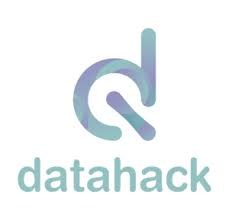